# Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import os
import pandas as pd

from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
pd.set_option('display.max_rows',500)

In [4]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [44]:
def flatten_columns(df):
    df.columns = df.columns.get_level_values(0)
    return df

In [5]:
def pq(qry,conn=conn):
    qry = qry.replace('from ','from predict.')
    return pd.read_sql(qry,conn)

In [6]:
def q(qry,conn=conn):
    return pd.read_sql(qry,conn)

In [7]:
def line_items_allocated_by_weight(component, start, end):
    qry = f"""
        with formulations as (
            select formulation_id, 
              component_id,
              component_pct / 100.0 as component_pct
            from warehouse.br_formulation_to_component
            where component_id = {component}
        ),
        sku_formulations as (
            select distinct s.sku_id,
              s.sku_name,
              s.formulation_id,
              f.*
            from warehouse.dm_skus s
            inner join formulations f 
            using (formulation_id)
        ),
        line_item_status as (
          select farm_id,
            delivery_scheduled_on,
            weight_ordered_lbs * component_pct as component_weight_ordered_lbs,
            weight_allocated_lbs * component_pct as component_weight_allocated_lbs,
            (component_weight_ordered_lbs - component_weight_allocated_lbs) as component_shortfall
          from warehouse.dm_line_Items
          inner join sku_formulations using (sku_id)
          where delivery_scheduled_on between '{start}' and '{end}'
            and channel_category not in ('non-revenue','offload')
            and order_status != 'canceled'
        )
        select farm_id,
          delivery_scheduled_on,
          sum(component_weight_ordered_lbs) as component_weight_ordered_lbs,
          sum(component_shortfall) as component_shortfall_lbs
        from line_item_status
        group by farm_id,
          delivery_scheduled_on
    """
    return q(qry,conn)

In [77]:
def actual_vs_li_plot():


    START_DT = datetime.datetime.strptime(START_DATE,'%Y-%m-%d')
    END_DT = datetime.datetime.strptime(END_DATE,'%Y-%m-%d')

    g = (
        computed_actuals.filter(items=['FARM_ID','FACT_DATE','COMPONENT_SHORTFALL_LBS'])
        .assign(SOURCE = 'computed')
        .pipe(lambda x: pd.concat([x,
                                   line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                                   .assign(SOURCE = 'line_items')],axis=0))
        .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
        .query('FARM_ID.isin([1,2])')
        .query("dt >= @START_DT")
        .query("dt <= @END_DT")
        .pipe(lambda frame: ggplot(frame, aes(x='dt',y='COMPONENT_SHORTFALL_LBS',color='SOURCE'))
              + geom_hline(yintercept=0,color='red')
              + geom_line()
              + geom_point(size=3)
              + facet_wrap('FARM_ID', scales='free',ncol=1)
              + theme_bw()
              + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(7,7))
              + ggtitle(f'Component {COMPONENT_ID}\nComputed Actual vs Observed Shortfall\n{START_DATE} - {END_DATE}')
             )
    )
    return g

# Basil

In [78]:
COMPONENT_ID = "15"

## 4/1/22 - 6/1/22

In [79]:
START_DATE = '2022-04-01'
END_DATE = '2022-06-01'

In [80]:
# Computed actuals
qry = f"""
    select *, 
      shortfall_lbs as component_shortfall_lbs
    from predict.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
      and fact_date between '{START_DATE}' and '{END_DATE}'
      and is_latest_prediction = True
"""

computed_actuals = q(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,0,2022-06-01,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaT,NaT,NaN,None,None,None,None,None,True,0.000000
1,2,2022-05-31,None,15,Basil,536.71875,220.645426,67.834516,149.673757,253.59375,...,2022-05-31 23:15:56,2022-05-31 19:15:56,NaN,None,None,None,43214579-a301-5b43-8cc1-1e690731be69,True,True,-312.330007
2,2,2022-04-23,None,15,Basil,710.34375,103.914972,NaN,NaN,90.00000,...,2022-04-23 23:16:42,2022-04-23 19:16:42,NaN,None,None,None,e1630811-e1ef-5b52-ad08-52cf6a815bac,True,True,-90.000000


In [81]:
line_items_allocated_weight = line_items_allocated_by_weight(COMPONENT_ID, START_DATE, END_DATE)
line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,COMPONENT_WEIGHT_ORDERED_LBS,COMPONENT_SHORTFALL_LBS
0,2,2022-04-20,88.12500,0.0
1,1,2022-05-23,0.93750,0.0
2,2,2022-05-03,250.31250,0.0
3,2,2022-04-06,92.81250,0.0
4,2,2022-04-25,89.53125,0.0


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


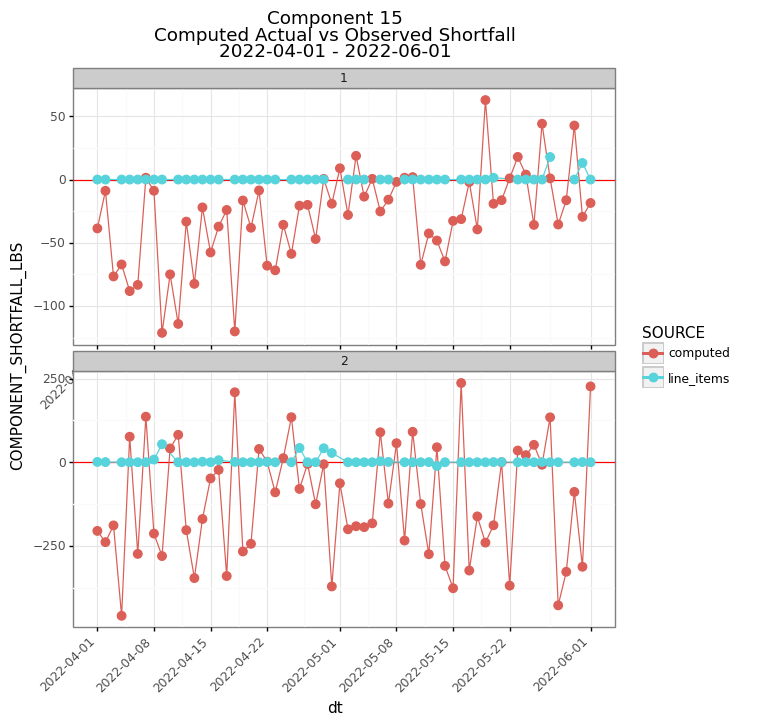

<ggplot: (366609336)>

In [82]:
actual_vs_li_plot()

## 1/1/21 - 12/13/21

In [83]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [84]:
# Computed actuals
qry = f"""
    select *, 
      shortfall_lbs as component_shortfall_lbs
    from predict.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = q(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,0,2021-11-13,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaT,NaT,NaN,None,None,None,None,None,True,0.0
1,0,2021-06-07,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaT,NaT,NaN,None,None,None,None,None,True,0.0
2,0,2021-12-19,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaT,NaT,NaN,None,None,None,None,None,True,0.0


In [85]:
computed_actuals.assign(dt = lambda x: pd.to_datetime(x['FACT_DATE'])).query("dt == '2021-09-01'").T

,435,815,903
FARM_ID,0,2,1
FACT_DATE,2021-09-01,2021-09-01,2021-09-01
REFERENCE_DATE,None,None,None
COMPONENT_ID,15,15,15
COMPONENT_NAME,Basil,Basil,Basil
CASE_INVENTORY_LBS,NaN,248.438,125.719
BIN_INVENTORY_LBS,5.80919,NaN,9.24619
RECENT_HARVEST_TO_PACK_PCT,NaN,NaN,87.6571
BIN_INVENTORY_PACKED_ESTIMATION_LBS,NaN,NaN,8.10495
PACKED_LBS,NaN,NaN,96.5625


In [86]:
line_items_allocated_weight = line_items_allocated_by_weight(COMPONENT_ID, START_DATE, END_DATE)
line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,COMPONENT_WEIGHT_ORDERED_LBS,COMPONENT_SHORTFALL_LBS
0,1,2021-02-25,22.50000,0.00000
1,2,2021-05-24,87.18750,0.00000
2,2,2021-10-07,158.90625,86.71875
3,1,2021-05-18,45.00000,0.00000
4,1,2021-08-09,36.56250,1.40625


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


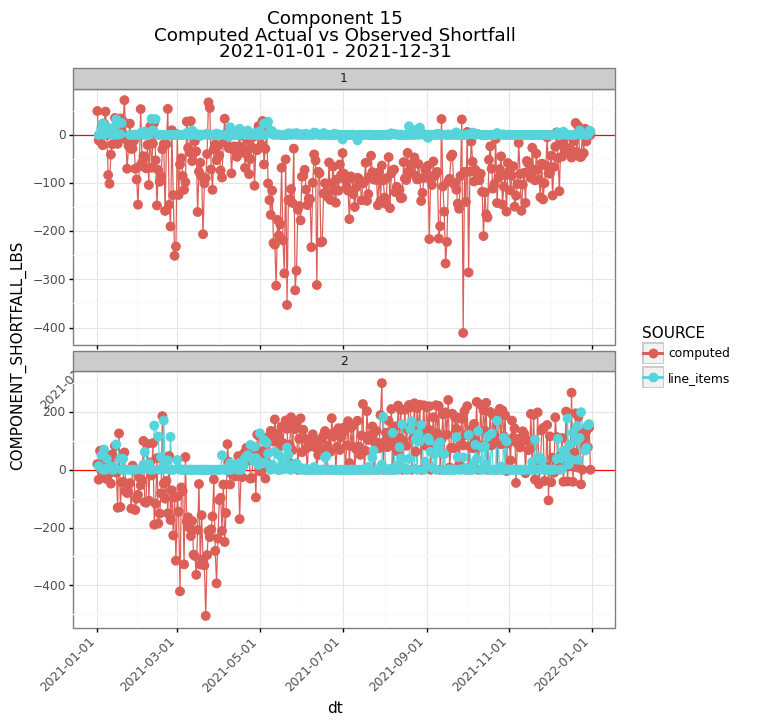

<ggplot: (363938317)>

In [87]:
actual_vs_li_plot()

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


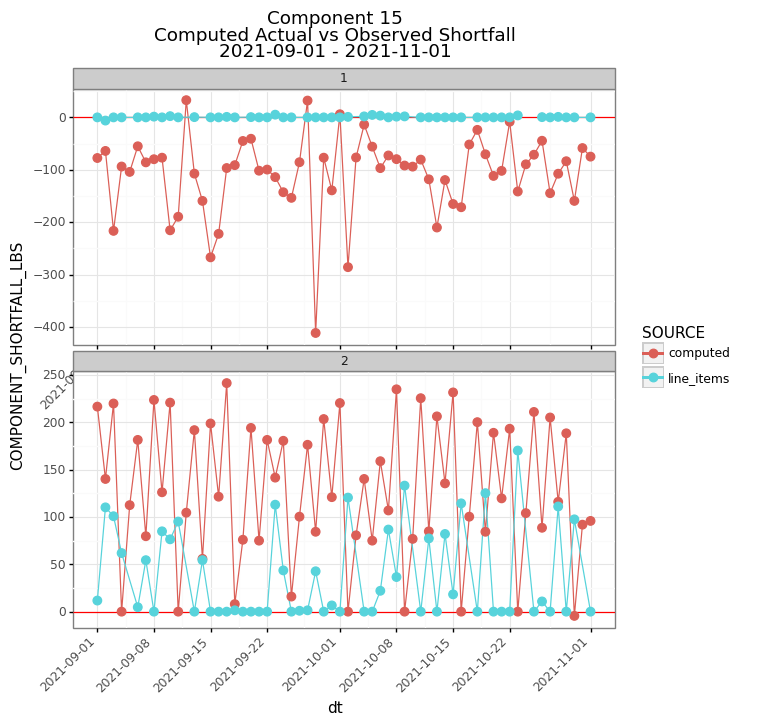

<ggplot: (359479851)>

In [88]:
START_DATE = '2021-09-01'
END_DATE = '2021-11-01'

actual_vs_li_plot()

In [89]:
## does this correspond to tranship activity?
COMPONENT_ID = 15
qry = f"""
    with formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),

    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join formulations using (formulation_id)
    ),
    line_items as (
        select l.*
        from warehouse.dm_line_items l
        inner join sku_formulations s using (sku_id)
        where delivery_scheduled_on between '2021-09-30' and '2021-11-01'
    ),
    cases as (
        select d.*, l.delivery_scheduled_on
        from warehouse.dm_cases d
        inner join line_items l using (order_id, sku_id)
    ),
    sums as (
        select farm_id,
          delivery_scheduled_on,
          sku_id,
          sum(case when source_farm_id <> farm_id then 1 else 0 end) as is_tranship,
          count(distinct case_id) as n_cases
        from cases 
        group by farm_id, delivery_scheduled_on, sku_id
    )
    select * from sums
"""
transship_sums = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


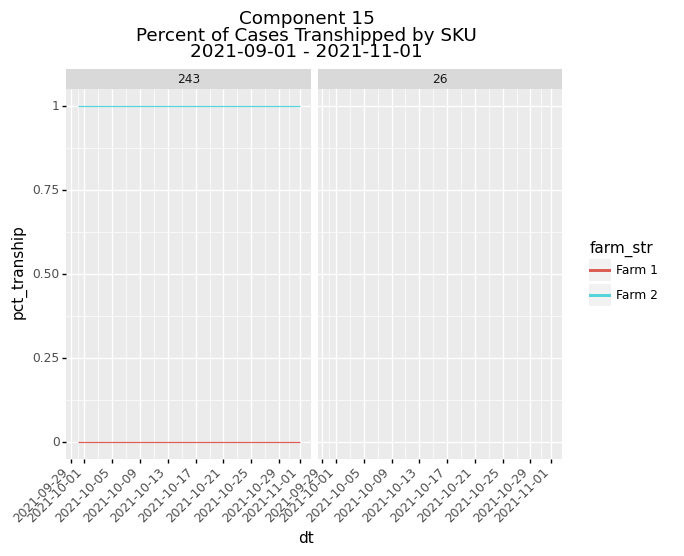

<ggplot: (361520005)>

In [90]:
(
    transship_sums
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: "Farm "+x['FARM_ID'].astype(str))
    .assign(sku_str = lambda x: x['SKU_ID'].astype(str))
    .assign(pct_tranship = lambda x: x['IS_TRANSHIP']/x['N_CASES'])
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='pct_tranship',color='farm_str')) 
         + geom_line() 
         + theme(axis_text_x=element_text(hjust=1,rotation=45))
         + facet_wrap('sku_str')
         + ggtitle(f'Component {COMPONENT_ID}\nPercent of Cases Transhipped by SKU\n{START_DATE} - {END_DATE}')
         )
)

## Residuals

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


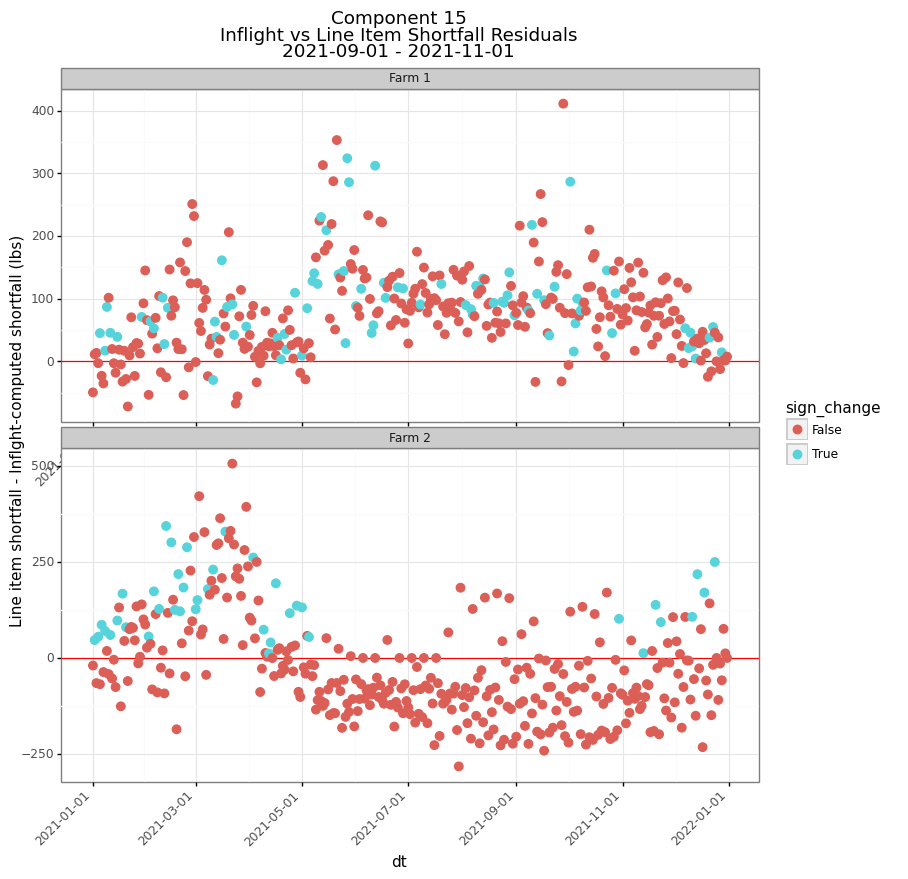

<ggplot: (363961164)>

In [42]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','COMPONENT_SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['COMPONENT_SHORTFALL_LBS'])
    .fillna(0)
    .assign(residuals = lambda x: x['COMPONENT_SHORTFALL_LBS']['line_items'] - x['COMPONENT_SHORTFALL_LBS']['computed'])
    .assign(sign_change = lambda x: (
        ((x['COMPONENT_SHORTFALL_LBS']['computed'] > 0) & (x['COMPONENT_SHORTFALL_LBS']['line_items'] < 0)) |
        ((x['COMPONENT_SHORTFALL_LBS']['computed'] < 0) & (x['COMPONENT_SHORTFALL_LBS']['line_items'] > 0))
           )
           )
    .reset_index()
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='residuals',color='sign_change'))
          + geom_hline(yintercept=0,color='red')
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free',ncol=1)
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
          + labs(y="Line item shortfall - Inflght-computed shortfall (lbs)")
          + ggtitle(f"Component {COMPONENT_ID}\nInflight vs Line Item Shortfall Residuals\n{START_DATE} - {END_DATE}")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


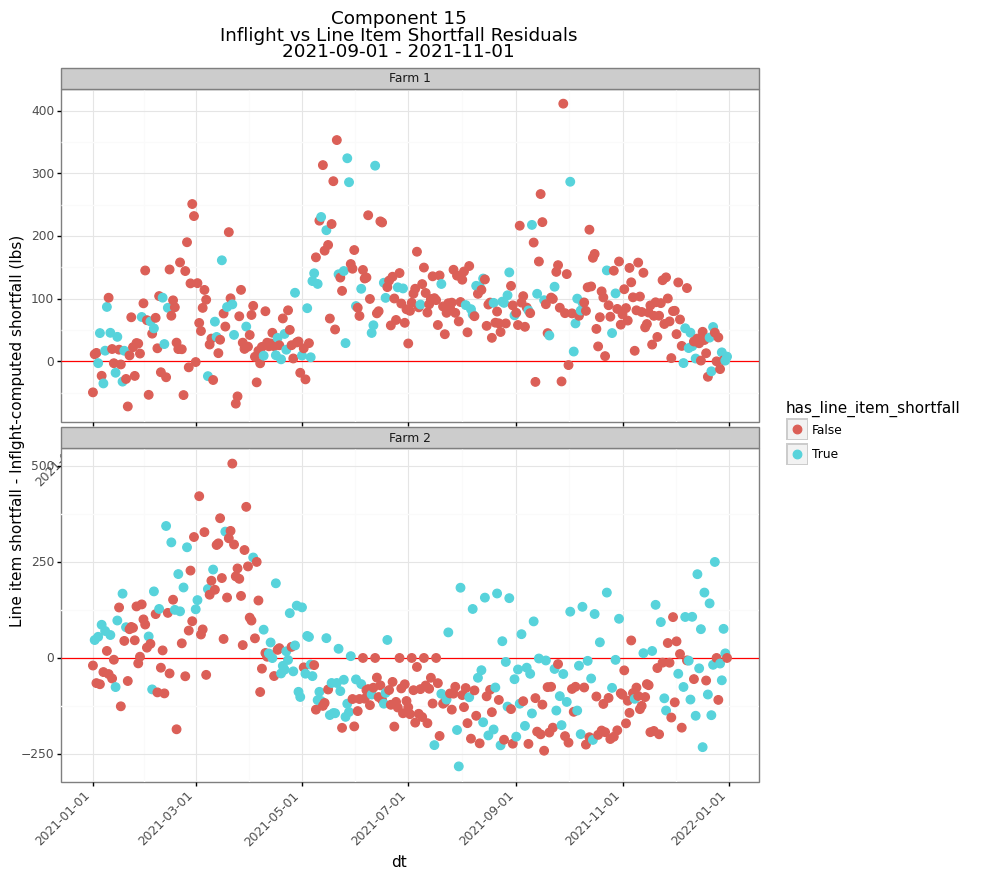

<ggplot: (366288616)>

In [91]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','COMPONENT_SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['COMPONENT_SHORTFALL_LBS'])
    .fillna(0)
    .assign(has_line_item_shortfall = lambda x: x['COMPONENT_SHORTFALL_LBS']['line_items'] > 0)
    .assign(residuals = lambda x: x['COMPONENT_SHORTFALL_LBS']['line_items'] - x['COMPONENT_SHORTFALL_LBS']['computed'])

    .reset_index()
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='residuals',color='has_line_item_shortfall'))
          + geom_hline(yintercept=0,color='red')
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free',ncol=1)
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
          + labs(y="Line item shortfall - Inflght-computed shortfall (lbs)")
          + ggtitle(f"Component {COMPONENT_ID}\nInflight vs Line Item Shortfall Residuals\n{START_DATE} - {END_DATE}")
         )
)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


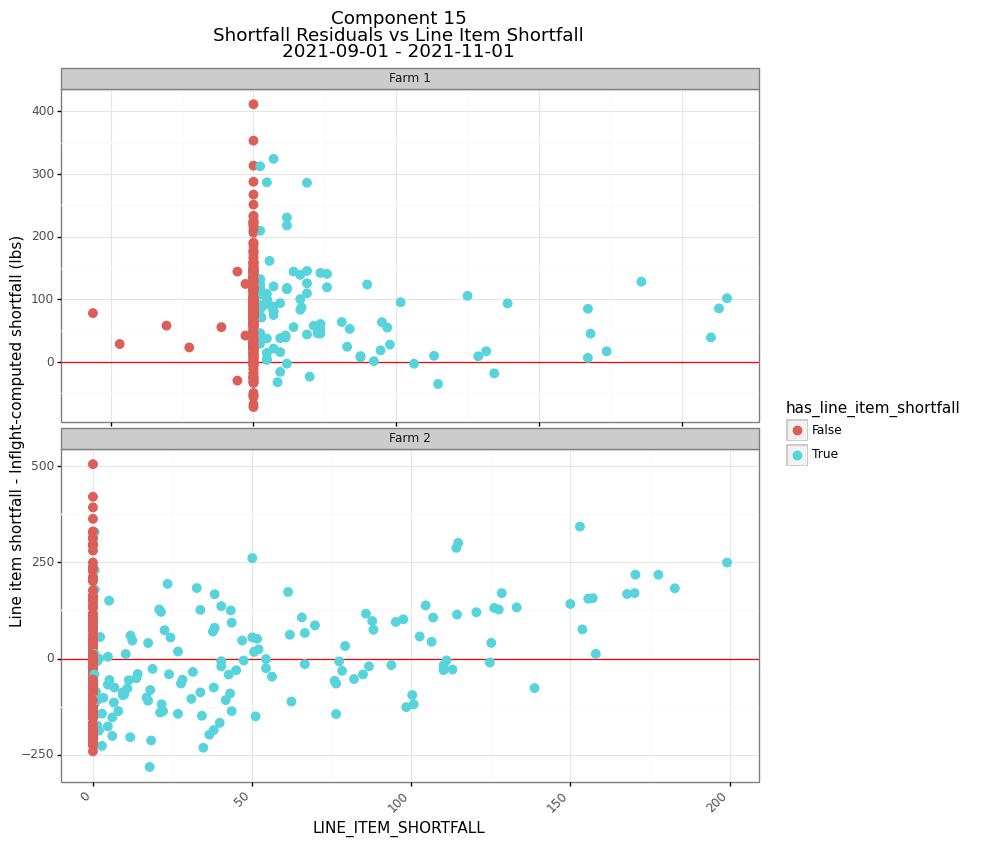

<ggplot: (366465428)>

In [92]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','COMPONENT_SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .query("FARM_ID != 0")
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pivot(index=['FARM_ID','dt'],columns=['SOURCE'],values=['COMPONENT_SHORTFALL_LBS'])
    .fillna(0)
    .assign(has_line_item_shortfall = lambda x: x['COMPONENT_SHORTFALL_LBS']['line_items'] > 0)
    .assign(residuals = lambda x: x['COMPONENT_SHORTFALL_LBS']['line_items'] - x['COMPONENT_SHORTFALL_LBS']['computed'])
    
    .drop('computed',axis=1,level=1)
    .pipe(flatten_columns)
    .rename(columns={'COMPONENT_SHORTFALL_LBS':'LINE_ITEM_SHORTFALL'})

    .reset_index()
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    .pipe(lambda frame: ggplot(frame, aes(x='LINE_ITEM_SHORTFALL',y='residuals',color='has_line_item_shortfall'))
          + geom_hline(yintercept=0,color='red')
          + geom_point(size=3)
          + facet_wrap('farm_str', scales='free',ncol=1)
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
          + labs(y="Line item shortfall - Inflght-computed shortfall (lbs)")
          + ggtitle(f"Component {COMPONENT_ID}\nShortfall Residuals vs Line Item Shortfall\n{START_DATE} - {END_DATE}")
         )
)

## Deep dive: F1, 3/16

In [68]:
(
    computed_actuals
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt == datetime.date(2021,3,16)')
    .query("FARM_ID==1")
    .T
)

,820
FARM_ID,1
FACT_DATE,2021-03-16
REFERENCE_DATE,None
COMPONENT_ID,15
COMPONENT_NAME,Basil
CASE_INVENTORY_LBS,1129.75
BIN_INVENTORY_LBS,132.295
RECENT_HARVEST_TO_PACK_PCT,53.8335
BIN_INVENTORY_PACKED_ESTIMATION_LBS,71.2191
PACKED_LBS,95.625


In [75]:
THIS_DATE = '2021-03-16'
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select li.*,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items li
        inner join sku_formulations f using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select *
    from line_item_status
    where delivery_scheduled_on = '{THIS_DATE}'
    and farm_id = 1
"""

li_316 = pd.read_sql(qry,conn)

li_316.head()

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
0,156,1,18980,65022,None,None,2,12,923,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-03-17 21:00:02.437168,boweryos,0.0000
1,156,1,18946,64805,None,None,1,81,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:11:54.531341,boweryos,0.0000
2,156,1,18951,64838,None,None,1,70,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:26:30.188159,boweryos,0.0000
3,156,1,18937,64701,None,None,72,211,1190,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-03-24 20:20:27.876757,boweryos,0.5625
4,156,1,18957,64883,None,None,1,7,919,33,...,208-51536-00719-3,8-51536-00719-9,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-03-24 20:13:03.260987,boweryos,0.0000


In [84]:
li_316.query("SHORTFALL > 0").T

,3,14
SKU_ID,156,156
FARM_ID,1,1
ORDER_ID,18937,18953
LINE_ITEM_ID,64701,64853
GS_ORDER_ID,None,None
GS_LINE_ITEM_ID,None,None
CUSTOMER_ID,72,1
CUSTOMER_LOCATION_ID,211,162
CUSTOMER_SKU_PROPERTY_ID,1190,919
FORMULATION_FAMILY_ID,33,33


In [86]:
li_316['WEIGHT_ORDERED_LBS'].sum()

51.75

In [ ]:
# We projected a surplus of 1200lbs but a few pounds shortfall?

In [89]:
qry = """
select *
from report.f_daily_case_inventory_by_component
where component_id = 15
and fact_date between '2021-03-14' and '2021-03-18'
and farm_id = 1
order by fact_date
"""
case_inv_316 = pd.read_sql(qry,conn)

In [91]:
case_inv_316.T

,0,1,2,3,4
FACT_DATE,2021-03-14,2021-03-15,2021-03-16,2021-03-17,2021-03-18
FARM_ID,1,1,1,1,1
COMPONENT_ID,15,15,15,15,15
COMPONENT_NAME,Basil,Basil,Basil,Basil,Basil
COMMERCIAL_CATEGORY,Herbs,Herbs,Herbs,Herbs,Herbs
STARTING_INVENTORY_LBS,1065.62,1084.75,1129.75,1182.06,1195.38
INCOMING_INVENTORY_LBS,33.75,55.6875,95.625,59.0625,58.875
OUTGOING_INVENTORY_LBS,1.125,36.5625,50.625,6.75,45.5625
ENDING_INVENTORY_LBS,1065.62,1084.75,1129.75,1182.06,1195.38
CASE_PACKED_LBS,33.75,55.6875,95.625,59.0625,58.875


In [ ]:
## So we did have a lot of case inventory.

In [ ]:
## Was it a question of having the wrong sku?

In [92]:
li_316.groupby('SKU_ID')['WEIGHT_ORDERED_LBS'].sum()

SKU_ID
156    51.75
Name: WEIGHT_ORDERED_LBS, dtype: float64

In [99]:
li_316.groupby('SKU_ID')['CASES_ORDERED_COUNT'].sum()

SKU_ID
156    92.0
Name: CASES_ORDERED_COUNT, dtype: float64

In [97]:
qry = """
    select *
    from report.f_daily_case_inventory_by_sku
    where sku_id = 156
    and fact_date between '2021-03-14' and '2021-03-18'
    and farm_id = 1
"""
inv_sku_age_316 = pd.read_sql(qry,conn)

In [98]:
inv_sku_age_316.T

,0,1,2,3,4
FACT_DATE,2021-03-14,2021-03-15,2021-03-16,2021-03-17,2021-03-18
FARM_ID,1,1,1,1,1
SKU_ID,156,156,156,156,156
SKU_NAME,Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell),Basil (6 x 1.5oz clamshell)
FORMULATION_FAMILY_ID,33,33,33,33,33
FORMULATION_FAMILY_NAME,Basil,Basil,Basil,Basil,Basil
CASE_WEIGHT_LBS,0.5625,0.5625,0.5625,0.5625,0.5625
STARTING_INVENTORY_COUNT,998,1056,1090,1170,1263
INCOMING_INVENTORY_COUNT,60,99,170,105,94
OUTGOING_INVENTORY_COUNT,2,65,90,12,81


In [100]:
## I'm not sure why we had a shortfall this day, but it seems to have been trivial.

## Deep Dive: F2 12/14

In [143]:
(
    computed_actuals
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt == datetime.date(2021,12,14)')
    .query("FARM_ID==2")
    .T
)

,735
FARM_ID,2
FACT_DATE,2021-12-14
REFERENCE_DATE,2021-12-01
COMPONENT_ID,15
COMPONENT_NAME,Basil
CASE_INVENTORY_LBS,181.406
BIN_INVENTORY_LBS,124.557
RECENT_HARVEST_TO_PACK_PCT,52.3248
BIN_INVENTORY_PACKED_ESTIMATION_LBS,65.1742
PACKED_LBS,83.4375


In [144]:
THIS_DATE = '2021-12-14'
FARM_ID = 2
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select li.*,
          (weight_ordered_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items li
        inner join sku_formulations f using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select *
    from line_item_status
    where delivery_scheduled_on = '{THIS_DATE}'
    and farm_id = {FARM_ID}
"""

li_1214 = pd.read_sql(qry,conn)

li_1214.head()

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
0,243,2,26315,106619,None,None,61,209,1590,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:12:38.760545,boweryos,0.0
1,243,2,26337,106761,None,None,81,256,1598,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:11:52.978068,boweryos,0.0
2,243,2,26217,106028,None,None,8,89,1679,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,6,2021-12-15 21:16:17.919373,boweryos,NaN
3,243,2,26316,106629,None,None,61,210,1590,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-14 21:12:20.290800,boweryos,0.0
4,243,2,26307,106464,None,None,3,14,1201,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,5,2021-12-15 21:16:44.097380,boweryos,NaN


In [150]:
li_1214.fillna(0).groupby(["CUSTOMER_ID",'SKU_ID','SHELF_LIFE_REQUIREMENT_DAYS'])[['WEIGHT_ALLOCATED_LBS','SHORTFALL']].sum()

,,,WEIGHT_ALLOCATED_LBS,SHORTFALL
CUSTOMER_ID,SKU_ID,SHELF_LIFE_REQUIREMENT_DAYS,,
3,243,5,0.0000,0.00000
8,243,6,0.0000,0.00000
53,243,4,28.1250,112.50000
57,243,5,12.1875,65.15625
59,243,5,2.8125,0.00000
61,243,5,2.8125,0.00000
81,243,5,0.9375,0.00000


In [ ]:
# 53 is albertsons, 57 is WFMA

In [151]:
li_1214.query("CUSTOMER_ID==53")

,SKU_ID,FARM_ID,ORDER_ID,LINE_ITEM_ID,GS_ORDER_ID,GS_LINE_ITEM_ID,CUSTOMER_ID,CUSTOMER_LOCATION_ID,CUSTOMER_SKU_PROPERTY_ID,FORMULATION_FAMILY_ID,...,GTIN,UPC,GMO_CERTIFIED,IS_DEFAULT_FORMULATION,CASE_DIMENSIONS,STORAGE_LOCATION_ID,SHELF_LIFE_REQUIREMENT_DAYS,VALID_FROM,DATA_SOURCE,SHORTFALL
5,243,2,24654,97592,None,None,53,236,1216,33,...,208-51536-00719-3,None,True,True,14 1/8 x 9 13/16 x 9 1/16,None,4,2021-12-14 21:10:42.049204,boweryos,112.5


In [155]:
li_1214.query("CUSTOMER_ID==53")['DELIVERY_SCHEDULED_ON']

5    2021-12-14
Name: DELIVERY_SCHEDULED_ON, dtype: object

In [152]:
qry = """
    select *
    from warehouse.dm_cases
    where sku_id = 243
    and order_id = 24654
"""
alb_cases = pd.read_sql(qry,conn)

In [154]:
alb_cases['CASE_ID'].nunique()

60

In [161]:
alb_cases.head()

,CASE_ID,FARM_ID,SOURCE_FARM_ID,PRODUCT_ID,SKU_ID,LINE_ITEM_ID,STORAGE_LOCATION_ID,PALLET_ID,LOT_NUMBER,UNIT_FORM_FACTOR,...,CLEARED_AT_LOCAL,PACKING_TASK_ID,PROCESSING_MACHINE_TYPES,IS_FROM_MANUAL_PACKING_TASK,IS_FROM_AUTO_FILL_PACKING_TASK,PACKING_TASK_COMPLETED_AT,PACKING_TASK_COMPLETED_AT_LOCAL,HOLD_PLACED_AT,HOLD_PLACED_AT_LOCAL,VALID_FROM
0,722296,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:45.954428
1,722401,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:41.362617
2,722295,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:45.534985
3,722380,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:23:42.161576
4,722208,2,2,None,243,97592,None,8363,25E239,clamshell,...,None,461148,None,None,None,2021-12-14 10:16:19.232175,2021-12-14 05:16:19.232175,None,None,2021-12-14 06:26:57.695874


In [160]:
alb_cases['SALABLE_MASS_LBS'].sum()

28.125

In [168]:
qry = """
select *
from report.f_hourly_case_inventory_by_sku_and_age
where sku_id = 243
and farm_id = 2
and hour_starting_at_local between '2021-12-13' and '2021-12-15'
"""
sku_and_age = pd.read_sql(qry,conn)
sku_and_age.head()

,HOUR_STARTING_AT,HOUR_STARTING_AT_LOCAL,FARM_ID,SKU_ID,SKU_NAME,FORMULATION_FAMILY_ID,FORMULATION_FAMILY_NAME,FORMULATION_ID,CASE_WEIGHT_LBS,AGE_HOURS,...,CASE_TRANSSHIPPED_INCOMING_COUNT,CASE_TRANSSHIPPED_OUTGOING_COUNT,CASE_QUALITY_LOSS_COUNT,CASE_OPERATIONAL_LOSS_COUNT,CASE_INTERNAL_USE_COUNT,CASE_MEASUREMENT_ERROR_COUNT,CASE_OTHER_COUNT,CASE_DONATED_COUNT,CASE_OFFLOAD_COUNT,CASE_PRIMARY_COUNT
0,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,6,...,0,0,0,0,0,0,0,0,0,0
1,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,7,...,0,0,0,0,0,0,0,0,0,0
2,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,8,...,0,0,0,0,0,0,0,0,0,0
3,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,9,...,0,0,0,0,0,0,0,0,0,0
4,2021-12-13 05:00:00,2021-12-13,2,243,Basil (6 x 1.25oz clamshell),33,Basil,33,0.46875,12,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# John suggested a miss like this could be saving inventory for a new client launch or other high importance order. 

In [217]:
SKU_IDs='243,26'
START_DATE = '2021-12-10'
END_DATE = '2021-12-25'

qry = f"""
with line_items as (
    select *, 
      weight_ordered_lbs - weight_allocated_lbs as shortfall
    from warehouse.dm_line_items
    where farm_id > 0
    and sku_id in ({SKU_IDs})
    and delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    and channel_category = 'primary'
    and order_status in ('shipped','delivered')
),
sums as (
    select farm_id,
      delivery_scheduled_on,
      customer_id,
      sum(weight_ordered_lbs) as weight_ordered_lbs,
      sum(weight_allocated_lbs) as weight_allocated_lbs,
      sum(shortfall) as shortfall
    from line_items
    group by farm_id,
      delivery_scheduled_on,
      customer_id
  )
select farm_id, 
  delivery_scheduled_on,
  customer_id, 
  weight_ordered_lbs,
  nvl(weight_allocated_lbs,0) as weight_allocated_lbs,
  (nvl(weight_allocated_lbs,0) / weight_ordered_lbs) as pct_fulfilled
from sums
"""

In [218]:
df = pd.read_sql(qry,conn)

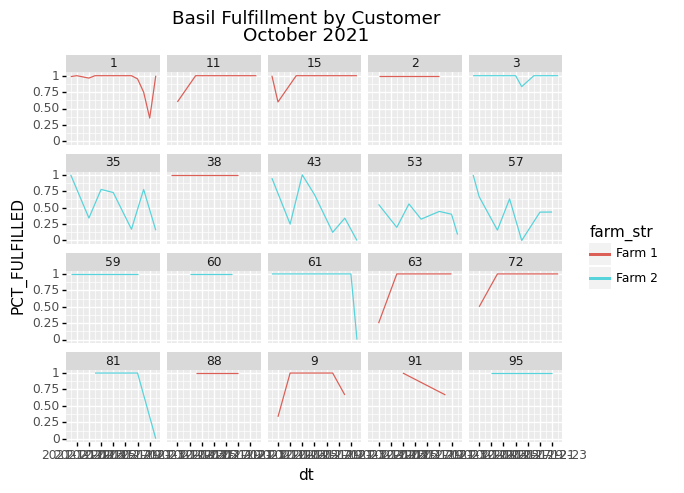

<ggplot: (369158202)>

In [222]:
(
    df
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: 'Farm '+x['FARM_ID'].astype(str))
    .assign(customer_str = lambda x: x['CUSTOMER_ID'].astype(str))
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='PCT_FULFILLED', color='farm_str')) 
          + geom_line()
          + facet_wrap('customer_str')
          + ggtitle("Basil Fulfillment by Customer\nOctober 2021"))
)

In [ ]:
# 100% for much or all include: 
# +-----------+----------------------+
# |CUSTOMER_ID|CUSTOMER_NAME         |
# +-----------+----------------------+
# |88         |Mulberry Market       |
# |72         |MaxDelivery           |
# |38         |Shoprite              |
# |11         |Westside Market       |
# |60         |Dawson's              |
# |15         |Brooklyn Fare         |
# |95         |Foxtrot               |
# |2          |Foragers              |
# |63         |Avo Now               |
# |61         |Graul's Market        |
# |59         |Eddie's of Roland Park|
# +-----------+----------------------+



# Baby Kale

In [93]:
COMPONENT_ID = 4

In [60]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

## Transship Frequency

In [62]:
## does this correspond to tranship activity?
qry = f"""
    with Formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),

    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join formulations using (formulation_id)
    ),
    line_items as (
        select l.*
        from warehouse.dm_line_items l
        inner join sku_formulations s using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    cases as (
        select d.*, l.delivery_scheduled_on
        from warehouse.dm_cases d
        inner join line_items l using (order_id, sku_id)
    ),
    sums as (
        select farm_id,
          delivery_scheduled_on,
          sku_id,
          sum(case when source_farm_id <> farm_id then 1 else 0 end) as is_tranship,
          count(distinct case_id) as n_cases
        from cases 
        group by farm_id, delivery_scheduled_on, sku_id
    )
    select * from sums
"""
transship_sums = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


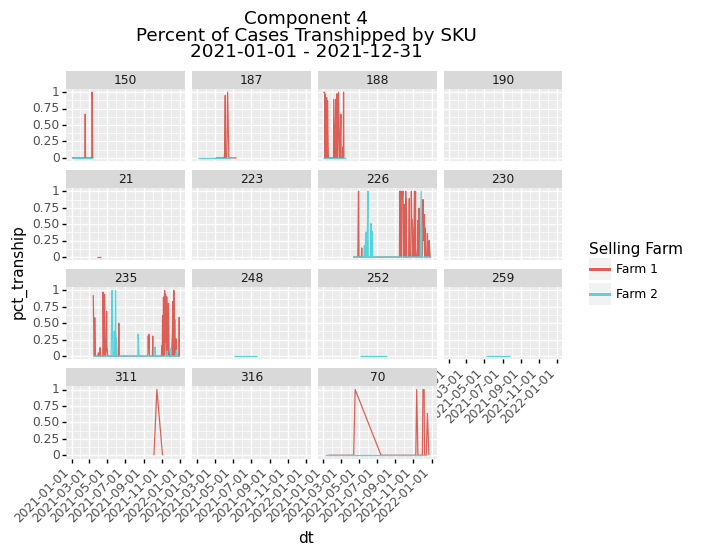

<ggplot: (364053330)>

In [64]:
(
    transship_sums
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: "Farm "+x['FARM_ID'].astype(str))
    .assign(sku_str = lambda x: x['SKU_ID'].astype(str))
    .assign(pct_tranship = lambda x: x['IS_TRANSHIP']/x['N_CASES'])
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='pct_tranship',color='farm_str')) 
         + geom_line() 
         + theme(axis_text_x=element_text(hjust=1,rotation=45))
         + facet_wrap('sku_str')
         + labs(color='Selling Farm')
         + ggtitle(f'Component {COMPONENT_ID}\nPercent of Cases Transhipped by SKU\n{START_DATE} - {END_DATE}')
         )
)

In [92]:
## does this correspond to tranship activity?
COMPONENT_ID = 4
START_DATE = '2021-05-01'
END_DATE = '2021-09-01'
qry = f"""
    with formulations as (
        select formulation_id, 
          component_id, 
          component_pct / 100.0 as component_pct
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sku_formulations as (
        select s.sku_id, 
          s.sku_name, 
          s.formulation_id,
          f.*
        from warehouse.dm_skus s
        inner join formulations f using (formulation_id)
    ),
    line_items as (
        select l.*
        from warehouse.dm_line_items l
        inner join sku_formulations s using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    cases as (
        select d.*, l.delivery_scheduled_on
        from warehouse.dm_cases d
        inner join line_items l using (order_id, sku_id)
    ),
    sums as (
        select farm_id,
          delivery_scheduled_on,
          sku_id,
          sum(case when source_farm_id <> farm_id then 1 else 0 end) as is_tranship,
          count(distinct case_id) as n_cases
        from cases 
        group by farm_id, delivery_scheduled_on, sku_id
    )
    select * from sums
"""
transship_sums = pd.read_sql(qry,conn)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


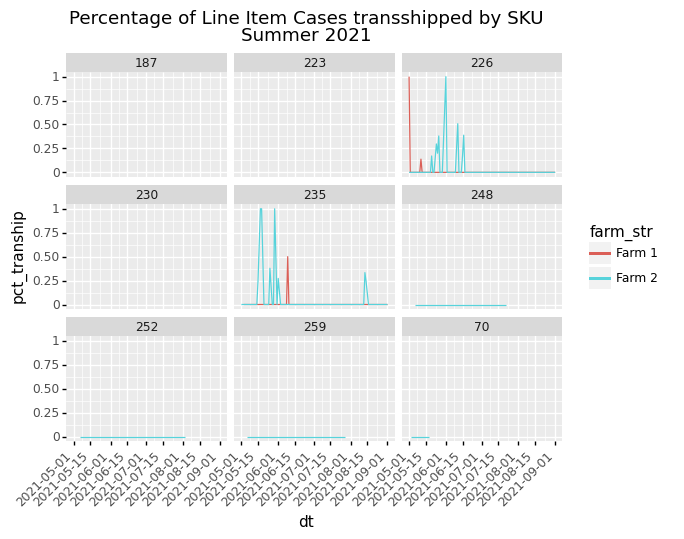

<ggplot: (364627941)>

In [93]:
(
    transship_sums
    .assign(dt = lambda x: pd.to_datetime(x['DELIVERY_SCHEDULED_ON']))
    .assign(farm_str = lambda x: "Farm "+x['FARM_ID'].astype(str))
    .assign(sku_str = lambda x: x['SKU_ID'].astype(str))
    .assign(pct_tranship = lambda x: x['IS_TRANSHIP']/x['N_CASES'])
    
    .pipe(lambda x: ggplot(x, aes(x='dt',y='pct_tranship',color='farm_str')) 
         + geom_line() 
         + theme(axis_text_x=element_text(hjust=1,rotation=45))
         + facet_wrap('sku_str')
         + ggtitle("Percentage of Line Item Cases transshipped by SKU\nSummer 2021"))
)

In [110]:
# upshot - little or no transshipping of baby kale in July 2021

## 1/1-12/31

In [94]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [95]:
# Computed actuals
qry = f"""
    select *, 
      shortfall_lbs as component_shortfall_lbs
    from predict.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
      and fact_date between '{START_DATE}' and '{END_DATE}'
      and is_latest_prediction = True
"""

computed_actuals = q(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,2,2021-10-28,None,4,Baby Kale,880.9350,72.948083,84.303871,61.498057,58.500000,...,NaT,NaT,NaN,None,None,None,None,None,True,13.456943
1,1,2021-09-30,None,4,Baby Kale,276.0675,43.865412,87.050968,38.185266,30.961745,...,NaT,NaT,NaN,None,None,None,None,None,True,-3.762011
2,1,2021-04-06,None,4,Baby Kale,489.2250,103.414522,73.161935,75.660066,45.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-119.310066


In [96]:
line_items_allocated_weight = line_items_allocated_by_weight(COMPONENT_ID, START_DATE, END_DATE)
line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,COMPONENT_WEIGHT_ORDERED_LBS,COMPONENT_SHORTFALL_LBS
0,1,2021-02-25,27.000,0.000
1,1,2021-05-18,61.950,3.495
2,1,2021-08-09,18.465,0.000
3,2,2021-05-24,142.125,1.980
4,2,2021-08-02,46.575,0.000


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


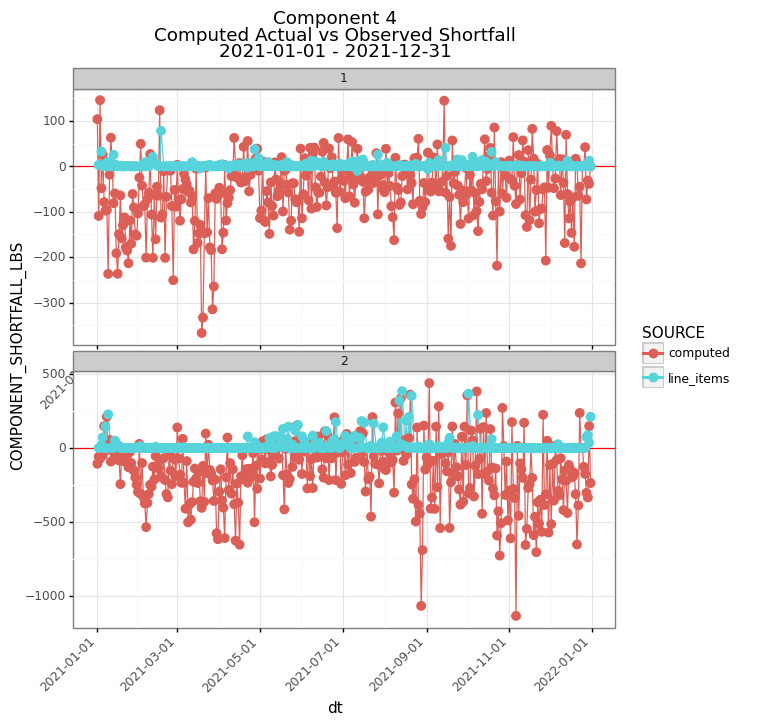

<ggplot: (366398678)>

In [97]:
actual_vs_li_plot()

## 5/1-8/1

In [98]:
START_DATE = '2021-05-01'
END_DATE = '2021-08-01'

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


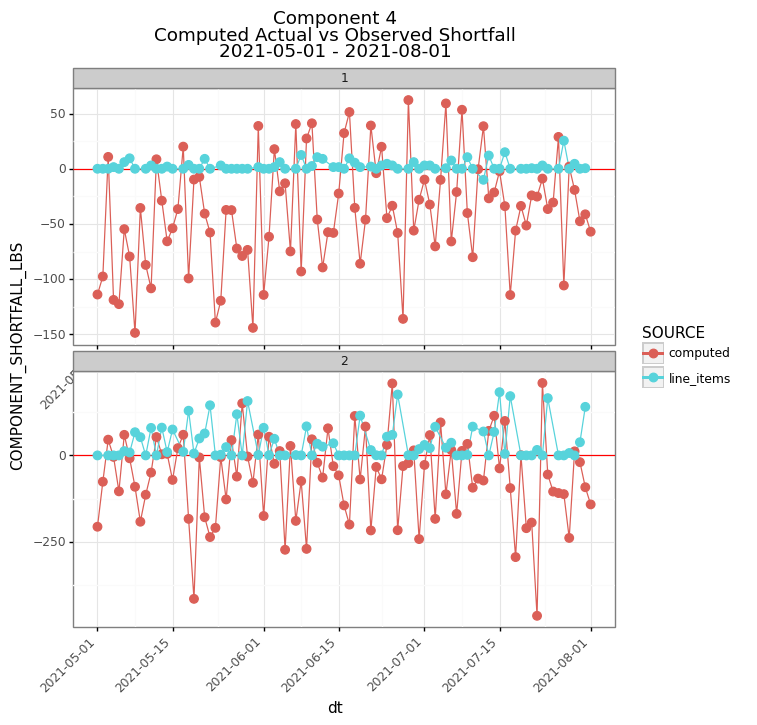

<ggplot: (366019127)>

In [99]:
actual_vs_li_plot()

## 7/1-8/1

In [100]:
START_DATE = '2021-07-01'
END_DATE = '2021-08-01'

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


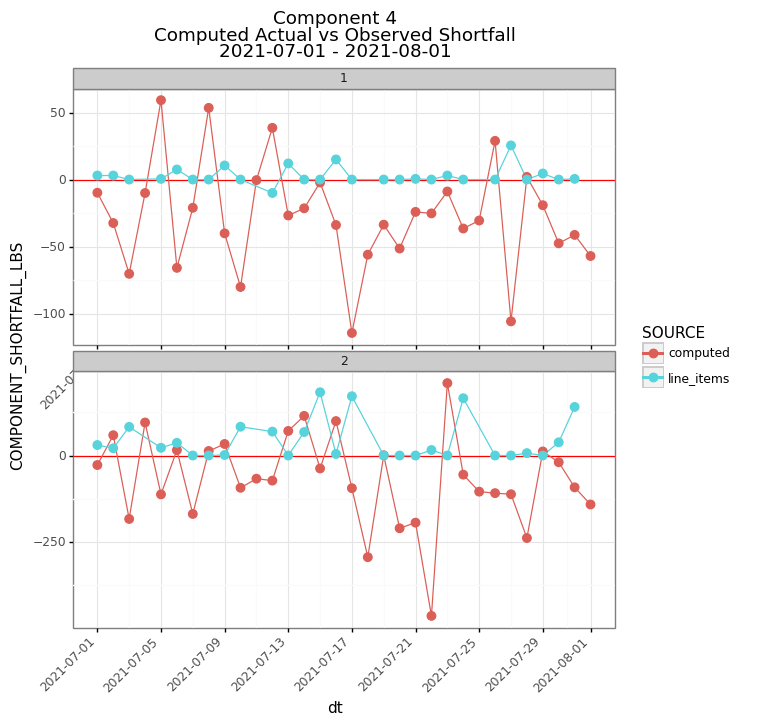

<ggplot: (366638812)>

In [101]:
actual_vs_li_plot()

## Deep Dive: Does just demand relate to actual?

In [102]:
COMPONENT_ID = 4
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [107]:
# Computed actuals
qry = f"""
    select *, 
      shortfall_lbs as component_shortfall_lbs
    from predict.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
      and fact_date between '{START_DATE}' and '{END_DATE}'
      and is_latest_prediction = True
"""

computed_actuals = q(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,2,2021-10-28,None,4,Baby Kale,880.9350,72.948083,84.303871,61.498057,58.500000,...,NaT,NaT,NaN,None,None,None,None,None,True,13.456943
1,1,2021-09-30,None,4,Baby Kale,276.0675,43.865412,87.050968,38.185266,30.961745,...,NaT,NaT,NaN,None,None,None,None,None,True,-3.762011
2,1,2021-04-06,None,4,Baby Kale,489.2250,103.414522,73.161935,75.660066,45.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-119.310066


In [104]:
line_items_ordered = line_items_allocated_by_weight(COMPONENT_ID, START_DATE, END_DATE)
line_items_ordered.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,COMPONENT_WEIGHT_ORDERED_LBS,COMPONENT_SHORTFALL_LBS
0,1,2021-02-25,27.000,0.000
1,1,2021-05-18,61.950,3.495
2,1,2021-08-09,18.465,0.000
3,2,2021-05-24,142.125,1.980
4,2,2021-08-02,46.575,0.000


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 107 rows containing missing values.


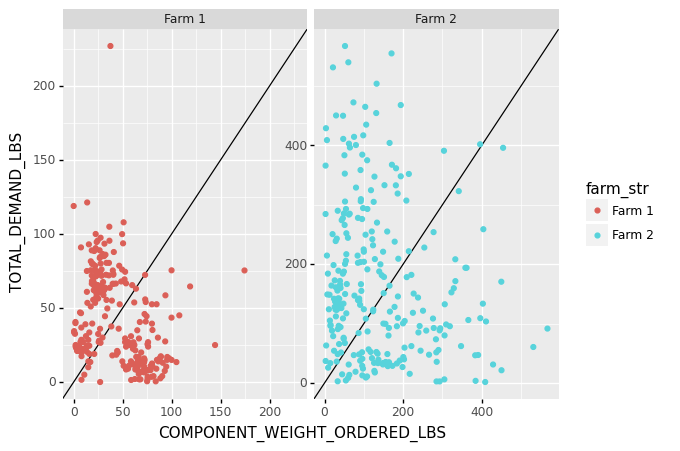

<ggplot: (366895345)>

In [113]:
(
    line_items_ordered
    .rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
    .pipe(lambda x: pd.merge(x, computed_actuals, on=['FARM_ID','FACT_DATE']))
    
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    
    .pipe(lambda x: ggplot(x, aes(x='COMPONENT_WEIGHT_ORDERED_LBS',y='TOTAL_DEMAND_LBS',color='farm_str'))
          + geom_abline(intercept=0,slope=1)          
         + geom_point()
         + facet_wrap('farm_str', scales='free'))
)

In [112]:
# virtually no relationship!

In [118]:
df = (
    line_items_ordered
    .rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
    .pipe(lambda x: pd.merge(x, computed_actuals, on=['FARM_ID','FACT_DATE']))
    
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
)

In [119]:
(
    df
    .query('(COMPONENT_WEIGHT_ORDERED_LBS / TOTAL_DEMAND_LBS) > 2')
    
    .query('dt == datetime.date(2021,2,22)')
    .query("FARM_ID==2")
).T

,32
FARM_ID,2
FACT_DATE,2021-02-22
COMPONENT_WEIGHT_ORDERED_LBS,60
SHORTFALL_LBS_x,0
REFERENCE_DATE,None
COMPONENT_ID,4
COMPONENT_NAME,Baby Kale
CASE_INVENTORY_LBS,358.35
BIN_INVENTORY_LBS,281.461
RECENT_HARVEST_TO_PACK_PCT,70.5658


In [117]:
# so computed total demand doesn't seem to match. Are the results different if I go back to the CTE?

COMPONENT_ID = 4
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'


qry = f"""

    -- straight from m_inflight_fulfillment.sql

    with daily_demand_by_component as (
      select
        l.farm_id,
        l.delivery_scheduled_on         as fact_date,
        f.component_id,
        f.component_name,
        sum(f.component_pct / 100 * l.weight_ordered_lbs) as total_demand_lbs
      from warehouse.dm_line_items l
      join warehouse.br_formulation_to_component f using (formulation_id)
      where l.order_status != 'canceled'
        and l.line_item_status = 'active'
        and l.channel_category not in  ('non-revenue', 'offload')
      group by 1, 2, 3, 4
    ),
    subset as (
        select *
        from daily_demand_by_component
        where component_id = {COMPONENT_ID}
        and fact_date between '{START_DATE}' AND '{END_DATE}'
    )
    select * from subset"""
demand_cte = pd.read_sql(qry,conn)

In [59]:
demand_cte

,FARM_ID,FACT_DATE,COMPONENT_ID,COMPONENT_NAME,TOTAL_DEMAND_LBS
0,1,2021-03-26,4,Baby Kale,66.300
1,1,2021-03-29,4,Baby Kale,18.600
2,1,2021-03-04,4,Baby Kale,36.750
3,2,2021-11-15,4,Baby Kale,51.990
4,1,2021-05-08,4,Baby Kale,22.470
...,...,...,...,...,...
613,1,2021-12-08,4,Baby Kale,14.940
614,2,2021-08-04,4,Baby Kale,32.670
615,1,2021-05-29,4,Baby Kale,14.955
616,1,2021-02-27,4,Baby Kale,54.000


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


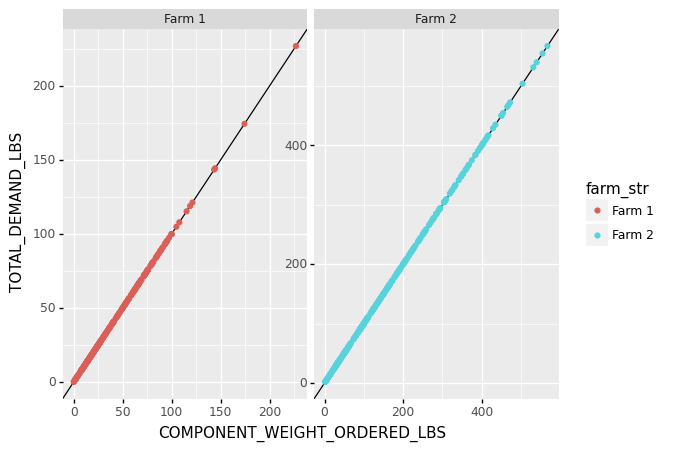

<ggplot: (366836908)>

In [122]:
# Compare my definition of observed line item shortfall to the demand cte
(
    line_items_ordered
    .rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
    .pipe(lambda x: pd.merge(x, demand_cte, on=['FARM_ID','FACT_DATE']))
    
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .assign(farm_str = lambda x: "Farm " + x['FARM_ID'].astype(str))
    
    .pipe(lambda x: ggplot(x, aes(x='COMPONENT_WEIGHT_ORDERED_LBS',y='TOTAL_DEMAND_LBS',color='farm_str'))
          + geom_abline(intercept=0,slope=1)    # formulation 32       
#           + geom_abline(intercept=0,slope=.3,color='green')   # formulation 37, 68, 46     

#           + geom_abline(intercept=0,slope=.35)   # formuation 96
#           + geom_abline(intercept=0,slope=.33, color='orange') # formulation 76


         + geom_point()
         + facet_wrap('farm_str',scales='free'))
)

In [125]:
demand_cte

,FARM_ID,FACT_DATE,COMPONENT_ID,COMPONENT_NAME,TOTAL_DEMAND_LBS
0,1,2021-01-16,4,Baby Kale,53.700
1,2,2021-12-10,4,Baby Kale,171.420
2,1,2021-05-08,4,Baby Kale,22.470
3,1,2021-11-13,4,Baby Kale,13.395
4,2,2021-04-09,4,Baby Kale,31.050
...,...,...,...,...,...
613,2,2021-05-01,4,Baby Kale,166.500
614,1,2021-01-09,4,Baby Kale,40.800
615,1,2021-06-16,4,Baby Kale,0.495
616,2,2021-08-04,4,Baby Kale,32.670


In [126]:
computed_actuals.head()

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,2,2021-10-28,None,4,Baby Kale,880.9350,72.948083,84.303871,61.498057,58.500000,...,NaT,NaT,NaN,None,None,None,None,None,True,13.456943
1,1,2021-09-30,None,4,Baby Kale,276.0675,43.865412,87.050968,38.185266,30.961745,...,NaT,NaT,NaN,None,None,None,None,None,True,-3.762011
2,1,2021-04-06,None,4,Baby Kale,489.2250,103.414522,73.161935,75.660066,45.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-119.310066
3,2,2021-04-08,None,4,Baby Kale,609.6000,287.892350,70.703548,203.550107,111.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-283.500107
4,2,2021-09-26,None,4,Baby Kale,407.8800,186.641299,86.159032,160.808337,111.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-382.313337


In [135]:
(
    demand_cte
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt > datetime.date(2021,5,1)')
    .query('dt < datetime.date(2021,5,10)')
    .sort_values('dt')
    .query('FARM_ID==2')
)

,FARM_ID,FACT_DATE,COMPONENT_ID,COMPONENT_NAME,TOTAL_DEMAND_LBS,dt
438,2,2021-05-03,4,Baby Kale,35.1450,2021-05-03
418,2,2021-05-04,4,Baby Kale,126.7050,2021-05-04
269,2,2021-05-05,4,Baby Kale,20.2950,2021-05-05
229,2,2021-05-06,4,Baby Kale,250.5750,2021-05-06
507,2,2021-05-07,4,Baby Kale,121.5675,2021-05-07
235,2,2021-05-08,4,Baby Kale,242.0325,2021-05-08
181,2,2021-05-09,4,Baby Kale,95.7825,2021-05-09


In [134]:
(
    computed_actuals
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .query('dt > datetime.date(2021,5,1)')
    .query('dt < datetime.date(2021,5,10)')
    .sort_values('dt')
    .query('FARM_ID==2')
    [['FARM_ID','dt','TOTAL_DEMAND_LBS']]
)

,FARM_ID,dt,TOTAL_DEMAND_LBS
85,2,2021-05-02,35.1450
551,2,2021-05-03,126.7050
44,2,2021-05-04,20.2950
137,2,2021-05-05,250.5750
681,2,2021-05-06,121.5675
320,2,2021-05-07,242.0325
33,2,2021-05-08,95.7825
707,2,2021-05-09,28.7550


In [107]:
# Computed actuals
qry = f"""
    select *, 
      shortfall_lbs as component_shortfall_lbs
    from predict.m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
      and fact_date between '{START_DATE}' and '{END_DATE}'
      and is_latest_prediction = True
      
"""

computed_actuals = q(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION,COMPONENT_SHORTFALL_LBS
0,2,2021-10-28,None,4,Baby Kale,880.9350,72.948083,84.303871,61.498057,58.500000,...,NaT,NaT,NaN,None,None,None,None,None,True,13.456943
1,1,2021-09-30,None,4,Baby Kale,276.0675,43.865412,87.050968,38.185266,30.961745,...,NaT,NaT,NaN,None,None,None,None,None,True,-3.762011
2,1,2021-04-06,None,4,Baby Kale,489.2250,103.414522,73.161935,75.660066,45.000000,...,NaT,NaT,NaN,None,None,None,None,None,True,-119.310066
